# Homework 4: Analyzing Rates of Sea Level Rise
In this homework, you'll investigate sea level change using data from the ECCO state estimate. You'll look at spatial differences over the past few decades and then compare how sea level on the California coast compares to the global mean.

Begin by importing the modules you'll need for this notebook:

In [1]:
# import packages here
import os
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc4
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.ticker import MaxNLocator

## Part 1: Download Sea Surface Height Data
To begin this exercise, download all of the available sea surface height data (1992-2017) from the ECCO Version 4 Release 4 output. There are several different variables for sea surface height pertaining to different components and corrections. In this homework, we'll use the `SSHDYN` variable which is equivalent to what satellites would measure from space.

To obtain the data, use the [Downloading ECCO Data](https://github.com/ProfMikeWood/ocean_modeling_book/blob/main/tools/Downloading%20ECCO%20Data.ipynb) notebook provided with the course notes.

In [2]:
# define the path to the folder where the SSH data has been download on your machine
ssh_folder = '/Users/harsita/Desktop/sjsu/year 3/spring 25/cs 185c - ocean modeling/data/ECCO/Version4/Release4/interp_monthly/SSHDYN'

## Part 2: Plot Total Sea Level Rise 1992-2017
As a first look into how sea level has changed in the past several decades, we'll look at the differences between two time periods at the beginning and end of the available model output: January 1992 and January 2017. It is important to use the same month because variations in sea level also have a seasonal cycle (as we'll see below). Begin by reading in the data:

In [3]:
file_1992 = os.path.join(ssh_folder, "SSHDYN_1992_01.nc")
file_2017 = os.path.join(ssh_folder, "SSHDYN_2017_01.nc")

# read in the longitude, latitude, and model ssh grid in January 1992 (SSHDYN_1992_01.nc)
ds_1992 = xr.open_dataset(file_1992)
ds_2017 = xr.open_dataset(file_2017)
lon = ds_1992["longitude"]  
lat = ds_1992["latitude"]

# read in the model ssh grid in January 2017 (SSHDYN_2017_01.nc)
ssh_1992 = ds_1992["SSHDYN"]
ssh_2017 = ds_2017["SSHDYN"]
print(ds_1992)
print(ds_2017)

<xarray.Dataset> Size: 2MB
Dimensions:    (i: 720, j: 360, time: 1, nv: 2)
Coordinates:
  * i          (i) int64 6kB 0 1 2 3 4 5 6 7 ... 712 713 714 715 716 717 718 719
  * j          (j) int64 3kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
  * time       (time) datetime64[ns] 8B 1992-01-16T12:00:00
    latitude   (j) float64 3kB ...
    longitude  (i) float64 6kB ...
    timestep   (time) int64 8B ...
    time_bnds  (time, nv) datetime64[ns] 16B ...
Dimensions without coordinates: nv
Data variables:
    SSHDYN     (time, j, i) float64 2MB ...
Attributes: (12/20)
    product_time_coverage_start:  1992-01-01T12:00:00
    author:                       Ou Wang and Ian Fenty
    Insitution:                   JPL
    product_version:              ECCO Version 4 Release 4
    time_units:                   days since 1992-01-01 00:00:00
    Conventions:                  CF-1.6
    ...                           ...
    nz:                           1
    geospatial_vertical_units:    

Now, make a plot of the difference between January 2017 and January 1992. Be sure to add a colorbar with a divergent colormaps and set the color bounds to be equal in the positive and negative directions.

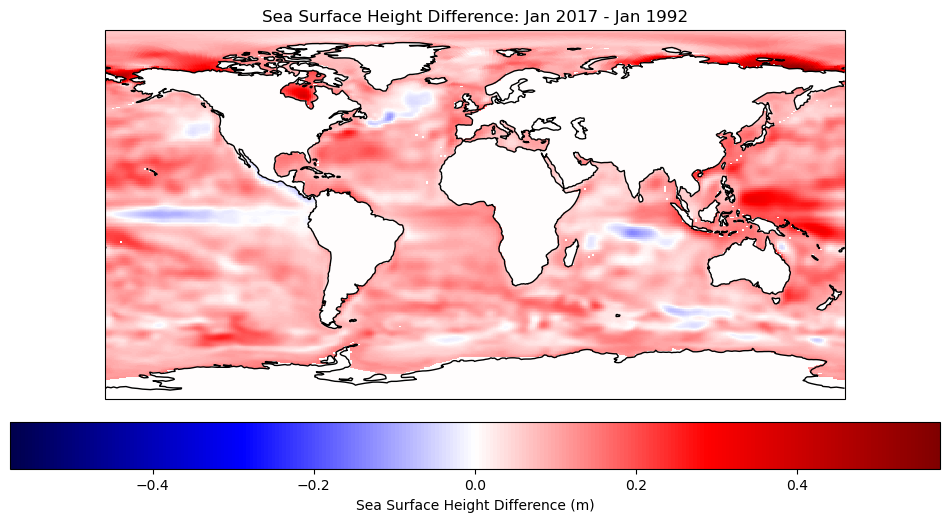

In [4]:
# make a plot of the differences between 2017 and 1992
# align dimensions to avoid mismatches
ssh_1992, ssh_2017 = xr.align(ssh_1992, ssh_2017, join="inner")

# select the first time step
ssh_1992 = ds_1992["SSHDYN"].isel(time=0)  
ssh_2017 = ds_2017["SSHDYN"].isel(time=0)

# compute SSH difference
ssh_diff = ssh_2017 - ssh_1992

# determine symmetric color limits
vmax = np.max(np.abs(ssh_diff))
vmin = -vmax

# create plot
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={"projection": ccrs.PlateCarree()})
cmap = "seismic"  

# plot data
plot = ax.pcolormesh(lon, lat, ssh_diff, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())

# add colorbar
cbar = plt.colorbar(plot, ax=ax, orientation="horizontal", pad=0.05)
cbar.set_label("Sea Surface Height Difference (m)")

# add coastlines
ax.coastlines()

# title
plt.title("Sea Surface Height Difference: Jan 2017 - Jan 1992")

# show plot
plt.show()

### Questions:
Where are the largest increases in sea level observed between these two time periods? Are there any locations on the globe where sea level has fallen? If so, where?

Answer: 
The largest increases in sea level are represented by the darkest red areas, which are concentrated in the western Pacific Ocean near Southeast Asia, the Indian Ocean, and parts of the North Atlantic Ocean near Greenland. Conversely, there are areas where sea levels have fallen, as indicated by the blue regions on the map. These include parts of the eastern Pacific Ocean near the west coast of South America and some areas in the Antarctic Ocean.

## Part 3: Create a Timeseries of Sea Surface Height in California
Next, we'll make a timeseries of sea surface height at a point off the California coast near San José. A close location in the model is at 37$^{\circ}$N, 122$^{\circ}$W. Begin by finding the closest row and column in the model grid to this longitude and latitude.

In [6]:
# define the latitude and longitude
lon = -122
lat = 37

# find the row and column closest to the location of the point off the CA coast
# note that you have already read in the longitude and latitude if the grid to make the plot above
lat_values = ds_1992["latitude"].values
lon_values = ds_1992["longitude"].values

closest_lat_idx = np.argmin(np.abs(lat_values - lat))
closest_lon_idx = np.argmin(np.abs(lon_values - lon))

print(f"closest latitude index: {closest_lat_idx}")
print(f"closest longitude index: {closest_lon_idx}")

closest latitude index: 253
closest longitude index: 115


Now, armed with your sample location, loop through each sea surface height file to make a timeseries of sea level rise between 1992 and 2017. Every time you access a file, sample the model grid at the row and column you identified above.

Text(0.5, 0, 'Time')

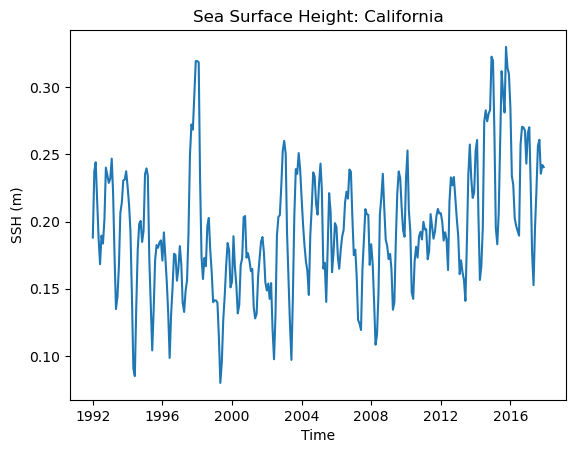

In [7]:
# create a timeseries of ssh at the point above by looping through all of the ssh files
# each time through the loop, sample the ssh grid at the row and column identified above
# your timeseries should be an (N,2) array with time in the first column and ssh values in the second

# initialize an empty array to store time series data 
ca_timeseries = np.empty((0, 2), dtype='object')

# iterate through the years from 1992 to 2017 (inclusive)
for year in range(1992, 2018):
    # iterate through the months from 1 to 12
    for month in range(1,13):
        file_path = os.path.join(ssh_folder,f'SSHDYN_{year}_{month:02d}.nc')
        ds = xr.open_dataset(file_path)
        ssh = np.array(ds['SSHDYN'])
        ds.close()
        
        # append the first SSHDYN value for the specified lat/lon and the corresponding datetime to the timeseries
        ca_timeseries = np.vstack([ca_timeseries, [ssh[0, closest_lat_idx, closest_lon_idx], np.datetime64(f'{year}-{month:02d}')]])

plt.plot(ca_timeseries[:,1], ca_timeseries[:,0])
plt.title("Sea Surface Height: California")
plt.ylabel("SSH (m)")
plt.xlabel("Time")


## Part 4: Create a Timeseries of Global Mean Sea Surface Height
Next, make a timeseries of sea surface height averaged across the globe. Your loop should look quite similar to that above - you'll just need to make a slight change to average across the whole ocean rather than sampling at a single point.

Text(0.5, 0, 'Time')

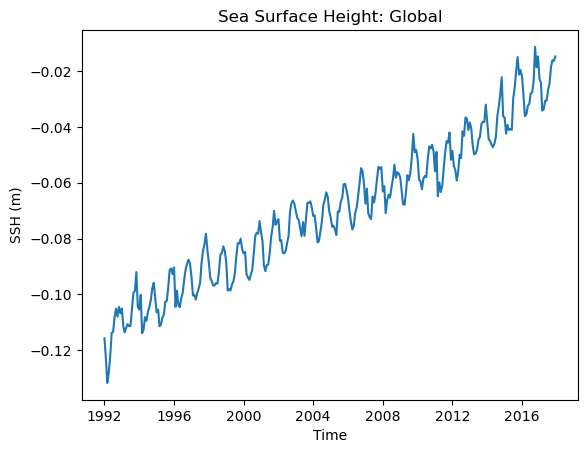

In [8]:
# create a timeseries of the global mean ssh by looping through all of the ssh files
# each time through the loop, take the mean of the ssh grid at the row and column identified above
# when you take the mean, be sure to exclude 0 values, which pertain to land
# your timeseries should be an (N,2) array with time in the first column and ssh values in the second
global_timeseries = np.empty((0, 2))
for year in range(1992, 2018):
    for month in range(1,13):
        file_path = os.path.join(ssh_folder, f'SSHDYN_{year}_{month:02d}.nc')
        ds = xr.open_dataset(file_path)
        ssh = np.array(ds['SSHDYN'])
        SSH = ssh[ssh != 0].mean()
        ds.close()
        global_timeseries = np.vstack([global_timeseries, [SSH, np.datetime64(f'{year}-{month:02d}')]])
    

plt.plot(global_timeseries[:,1], global_timeseries[:,0])
plt.title("Sea Surface Height: Global")
plt.ylabel("SSH (m)")
plt.xlabel("Time")

## Part 5: Compute Trends in Sea Surface Height
To compare the two timeseries, compute trends by fitting a line to each timeseries and examining the slope. Print out each trend in mm/yr, rounded to 2 decimal places. Note that the units of sea surface height are in meters.

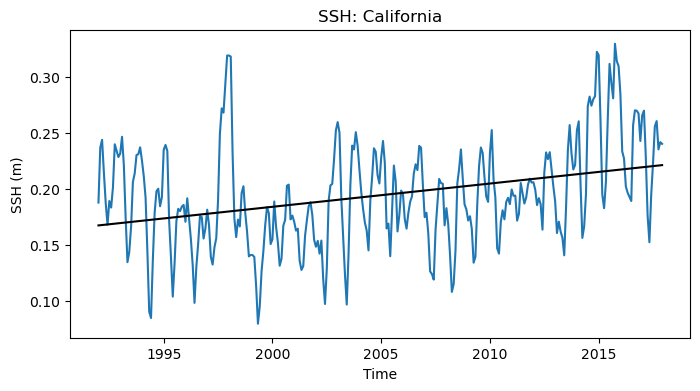

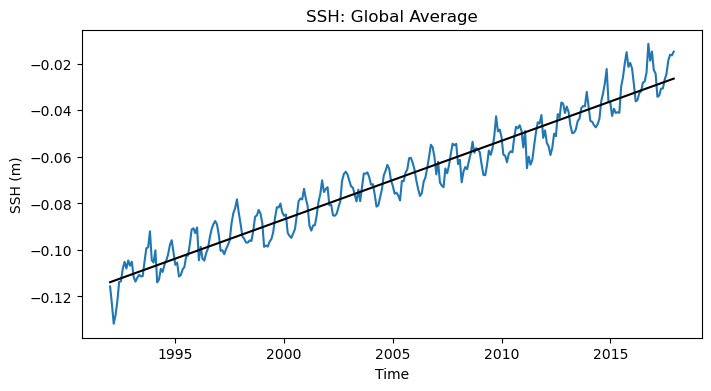

California: 2.08 mm/yr 
Global: 3.38 mm/yr


In [9]:
# compute the trends in SLR by fitting a line to the CA and the global mean timeseries
# create an array representing the months as integers
months = np.arange(len(ca_timeseries))

# convert months to decimal years starting from 1992
dec_yr = 1992 + months/12

# fit a linear regression model to the data (dec_yr vs SSHDYN for California)
p = np.polyfit(dec_yr, ca_timeseries[:,0].astype(float), 1)

# extract the slope and intercept from the polynomial fit
ca_slope = p[0]
ca_intercept = p[1]

# create a figure for plotting California's SSHDYN data
fig = plt.figure(figsize=(8,4))

# plot the SSHDYN data for California over time
plt.plot(dec_yr, ca_timeseries[:,0])

# plot the linear regression line (trendline) for California SSHDYN
plt.plot(dec_yr, ca_slope*dec_yr + ca_intercept, color='k')

# set the title and axis labels for the plot
plt.title("SSH: California")
plt.ylabel("SSH (m)")
plt.xlabel("Time")
plt.show()

# repeat the process for the global timeseries
months = np.arange(len(global_timeseries))

# convert months to decimal years starting from 1992
dec_yr = 1992 + months/12

# fit a linear regression model to the global timeseries data
p = np.polyfit(dec_yr, global_timeseries[:,0].astype(float), 1)

# extract the slope and intercept from the global regression model
slope = p[0]
intercept = p[1]

# create a figure for plotting global SSHDYN data
fig = plt.figure(figsize=(8,4))

# plot the SSHDYN data for global average over time
plt.plot(dec_yr, global_timeseries[:,0])

# plot the linear regression line (trendline) for global SSHDYN
plt.plot(dec_yr, slope*dec_yr + intercept, color='k')

# set the title and axis labels for the plot
plt.title("SSH: Global Average")
plt.ylabel("SSH (m)")
plt.xlabel("Time")
plt.show()

# print out the slope values (in mm/yr) for each timeseries
print(f'California: {ca_slope*1000:.2f} mm/yr \nGlobal: {slope*1000:.2f} mm/yr')


### Question:
How does the trend in sea level rise in California compare to the global mean rate?

Answer: The rise in California's sea level seems to be slightly slower than the global average rate.

## Part 6: Plot the Timeseries of Sea Surface Height
Finally, plot the two timeseries on the same plot along with their trend lines. Be sure to label your axes and include a legend.

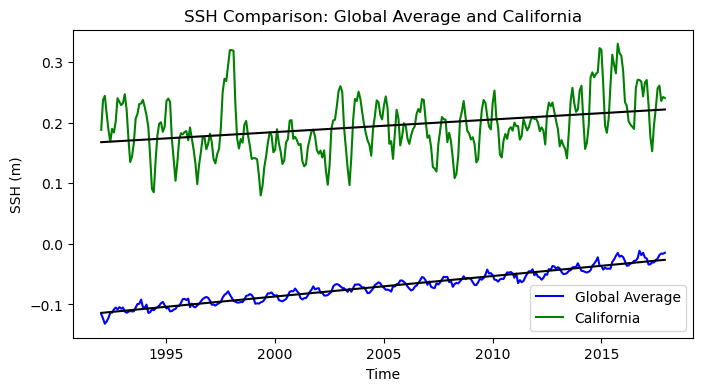

In [10]:
# create your plot here
fig = plt.figure(figsize=(8,4))

# plot global mean
plt.plot(dec_yr, global_timeseries[:,0], color='blue', label='Global Average')
plt.plot(dec_yr, slope*dec_yr + intercept, color='k')

# plot california
plt.plot(dec_yr, ca_timeseries[:,0], color='green',label='California')
plt.plot(dec_yr, ca_slope*dec_yr + ca_intercept, color='k')

# title and label
plt.title("SSH Comparison: Global Average and California")
plt.ylabel("SSH (m)")
plt.xlabel("Time")
plt.legend()
plt.show()

### Questions:

How do the timeseries for Calfiornia and the global mean compare? Comment on their variability. What are the two highest years of sea level in California? What oceanographic phenomenon happened during this time?

Answer: 
The time series in the graph compares sea surface height for California and the global mean. Both California and the global mean show an increasing trend in SSH over time, with the global mean showing a steadier rise, while California's SSH fluctuates more significantly around its upward trend. The California SSH time series shows much higher variability, with large fluctuations above and below the trendline, whereas the global mean SSH is smoother, with relatively minor fluctuations around its trend. The two highest peaks in California’s SSH occur around 1997–1998 and 2015–2016, coinciding with strong El Niño events. These events mean there were unusually warm ocean temperatures in the equatorial Pacific, which lead to higher sea levels along the California coast due to thermal expansion and changes in ocean currents.